In [5]:
import polars as pl
import glob, os
import json
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import seaborn as sns

import pyarrow


In [6]:
# !pip install pyarrow

In [29]:
# ===================== CONSTANT =========================
ALL_TIMELINE_JSON_PATH = "../res/data/matches/timelines/*.json"

In [8]:

# 1) Read all timeline JSON files (one file per match)
paths = glob.glob(ALL_TIMELINE_JSON_PATH)

dfs = []
for p in paths:
    df = pl.read_json(p).with_columns(
        pl.col("metadata").struct.json_encode().alias("metadata_json"),
        pl.col("info").struct.json_encode().alias("info_json"),
        pl.lit(os.path.basename(p)).alias("source_file"),
    ).select("metadata_json", "info_json", "source_file")
    dfs.append(df)

timeline_matches = pl.concat(dfs, how="diagonal", rechunk=True)



itemId mapId championId pickTurn
分析目标：

1. 单局游戏内行为：
某次游戏走向决策 / 对线失误问题 / 出装决策失误 / 英雄选择失误原因分析 / 对线思路 / 补刀 / 游戏节奏把握 / 执行力 / 对自己英雄的操作理解  / 对对手英雄的操作理解 / 和队友的配合 / 关键失误（没有及时落位，没有预判对手动作，没有卡住金身TP时间等等） （团战 和 对线 分开分析）

2. 游戏生涯分析：（剔除早早投降的局）
闪现/召唤师技能利用率
技能命中率
绝活输赢分析 carry局分析 第一次尝试英雄分析
游戏性格
需要哪种队友
警惕那种对手

3. 增加娱乐性，不能像学习一样， carry 的爽感 以及 唤起和好朋友的乐趣，和好朋友度过了哪些艰难局，谁carry了谁， 配合维度怎么样，亲和度怎么样

4. 专业性：自己和高端选手和职业选手的差距，如果你是应征青训选手，虚拟教练看好你哪里


In [9]:
# timeline_matches: 有 metadata_json / info_json / source_file 三列
rows = []
for m_json, i_json, src in timeline_matches.select(
        "metadata_json", "info_json", "source_file"
    ).iter_rows():
    m = json.loads(m_json)
    i = json.loads(i_json)
    rows.append({
        "match_id":       m.get("matchId"),
        "puuid_list":     m.get("participants"),
        "end_result":     i.get("endOfGameResult"),
        "frame_interval": i.get("frameInterval"),
        "frames":         i.get("frames"),
        "source_file":    src,
    })

decoded = pl.DataFrame(rows)


In [10]:
# 2) frames（每行=一场的一分钟）
frames = (
    decoded
    .explode("frames")
    .drop_nulls("frames")
    .unnest("frames")
    .with_columns((pl.col("timestamp")/60000).cast(pl.Int64).alias("minute"))
)

In [27]:
frames

match_id,puuid_list,end_result,frame_interval,events,participantFrames,timestamp,source_file,minute
str,list[str],str,i64,list[struct[38]],struct[16],i64,str,i64
"""EUW1_7460431991""","[""l-0H-IREJElPO_Q1cnCf3eb1NFNZC1HU5QpZa_6BM0foroMHJw0SMF7WuVEdie8wef7Y84M3I0UzcA"", ""0MYzLuIKha_ryS_jf8ZwmTT2Dzr9JK4ksX9w90L11ySalWG1z77-iO3mThOe2z7PW88O_zYyJDVxEA"", … ""a5bACEMwhWguyXZbaaKaJq8-Ks1tX0-DZsWT0p9MRQZ47z2WeeP7CUWJj8avtbCtgkaXlGa9Go3hDQ""]","""GameComplete""",60000,"[{null,null,null,null,null,null,0,""PAUSE_END"",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1752430310052,null,null,null,null,null,null,null,null,null,null,null,null}, {null,null,null,null,null,null,0,""ITEM_PURCHASED"",null,null,null,null,0,null,null,null,null,null,null,null,null,null,3865,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}, … {null,null,null,null,null,null,0,""ITEM_PURCHASED"",null,null,null,null,0,null,null,null,null,null,null,null,null,null,3865,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}]","{{{0,0,38,0,0,25,100,0,0,0,0,644,644,0,0,0,0,32,345,0,0,270,270,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,1,{554,581},0,500,0},{{0,0,33,0,0,25,100,0,0,0,0,669,669,0,0,0,0,32,355,0,0,251,251,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,2,{593,464},0,500,0},{{0,0,22,0,0,25,100,0,0,0,0,645,645,0,0,0,0,32,340,0,0,300,300,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,3,{557,345},0,500,0},{{0,0,24,0,0,25,100,0,0,0,0,655,655,0,0,0,0,30,330,0,0,300,300,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,4,{458,271},0,500,0},{{0,0,43,0,0,60,100,0,0,0,0,676,676,21,0,0,0,32,335,0,0,302,302,15,0},100,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,5,{335,269},0,500,0},{{0,0,34,0,0,25,100,0,0,0,0,610,610,0,0,0,0,32,340,0,0,400,400,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,6,{14500,14511},0,500,0},{{0,0,22,0,0,25,100,0,0,0,0,605,605,0,0,0,0,32,330,0,0,410,410,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,7,{14539,14394},0,500,0},{{0,0,25,0,0,25,100,0,0,0,0,563,563,0,0,0,0,30,330,0,0,480,480,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,8,{14503,14275},0,500,0},{{0,0,28,0,0,25,100,0,0,0,0,641,641,0,0,0,0,30,335,0,0,320,320,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,9,{14404,14201},0,500,0},{{0,0,26,0,0,48,100,0,0,0,0,590,590,12,0,0,0,30,330,0,0,365,365,28,0},100,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,10,{14281,14199},0,500,0},null,null,null,null,null,null}",0,"""EUW1_7460431991.json""",0
"""EUW1_7460431991""","[""l-0H-IREJElPO_Q1cnCf3eb1NFNZC1HU5QpZa_6BM0foroMHJw0SMF7WuVEdie8wef7Y84M3I0UzcA"", ""0MYzLuIKha_ryS_jf8ZwmTT2Dzr9JK4ksX9w90L11ySalWG1z77-iO3mThOe2z7PW88O_zYyJDVxEA"", … ""a5bACEMwhWguyXZbaaKaJq8-Ks1tX0-DZsWT0p9MRQZ47z2WeeP7CUWJj8avtbCtgkaXlGa9Go3hDQ""]","""GameComplete""",60000,"[{null,null,null,null,null,null,2750,""ITEM_PURCHASED"",null,null,null,null,8,null,null,null,null,null,null,null,null,null,1056,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}, {null,null,null,null,null,null,2750,""ITEM_PURCHASED"",null,null,null,null,8,null,null,null,null,null,null,null,null,null,2003,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}, … {null,null,null,null,null,null,56694,""SKILL_LEVEL_UP"",null,null,null,""NORMAL"",5,3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null}]","{{{0,18,38,0,0,69,110,0,0,0,0,754,754,18,0,0,0,32,345,0,0,270,270,14,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,1,{4957,8589},0,500,0},{{0,0,33,0,0,70,113,0,0,0,0,679,679,15,0,0,0,32,355,0,0,251,251,14,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,2,{8472,4758},0,500,0},{{0,9,22,0,0,58,110,0,0,0,0,655,655,16,0,0,0,32,340,0,0,544,544,16,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,3,{6354,6496},0,500,0},{{0,0,24,0,0,79,110,0,0,0,0,745,745,7,3,0,0,30,333,0,0,300,300,12,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,4,{11568,1910},0,500,0},{{0,0,43,0,0,60,100,0,0,0,0,696,696,21,0,0,0,32,335,0,0,302,302,15,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,5,{120

In [11]:
# 3) 事件表（避免 timestamp 重名）
events_all = (
    frames
    .select(
        "match_id",
        pl.col("timestamp").alias("frame_ts"),  # 帧级时间
        "minute",
        "events",
    )
    .explode("events")
    .drop_nulls("events")
    .unnest("events")                           # 这里会产生事件自己的 timestamp
    .rename({"timestamp": "event_ts"})          # 事件级时间改名
    .with_columns([
        (pl.col("frame_ts")/60000).cast(pl.Int64).alias("frame_minute"),
        # 有些事件可能没有 event_ts，用帧 minute 兜底
        pl.when(pl.col("event_ts").is_not_null())
          .then((pl.col("event_ts")/60000).cast(pl.Int64))
          .otherwise(pl.col("minute"))
          .alias("event_minute"),
    ])
)


In [28]:
events_all

match_id,frame_ts,minute,assistingParticipantIds,bounty,killStreakLength,killerId,position,shutdownBounty,event_ts,type,victimDamageDealt,victimDamageReceived,victimId,levelUpType,participantId,skillSlot,buildingType,laneType,teamId,towerType,level,wardType,killerTeamId,monsterType,itemId,creatorId,gameId,realTimestamp,winningTeam,featType,featValue,afterId,beforeId,goldGain,killType,name,monsterSubType,multiKillLength,actualStartTime,transformType,frame_minute,event_minute
str,i64,i64,list[i64],i64,i64,i64,struct[2],i64,i64,str,list[struct[9]],list[struct[9]],i64,str,i64,i64,str,str,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""PAUSE_END""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1752430310052,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""ITEM_PURCHASED""",null,null,null,null,0,null,null,null,null,null,null,null,null,null,3865,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""WARD_PLACED""",null,null,null,null,null,null,null,null,null,null,null,"""UNDEFINED""",null,null,null,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""ITEM_PURCHASED""",null,null,null,null,0,null,null,null,null,null,null,null,null,null,3865,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",60001,1,null,null,null,null,null,null,2750,"""ITEM_PURCHASED""",null,null,null,null,8,null,null,null,null,null,null,null,null,null,1056,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""EUW1_7553544945""",2155661,35,null,null,null,null,null,null,2141752,"""SKILL_LEVEL_UP""",null,null,null,"""NORMAL""",6,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35,35
"""EUW1_7553544945""",2155661,35,null,null,null,null,null,null,2143222,"""ITEM_PURCHASED""",null,null,null,null,3,null,null,null,null,null,null,null,null,null,1011,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35,35
"""EUW1_7553544945""",2155661,35,null,0,null,8,"{2177,1807}",null,2144491,"""BUILDING_KILL""",null,null,null,null,null,null,"""TOWER_BUILDING""","""MID_LANE""",100,"""NEXUS_TURRET""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35,35


In [12]:
# 4) participant_id <-> puuid
pid_map = (
    decoded
    .select("match_id", "puuid_list")
    .explode("puuid_list")
    .with_row_index("participant_id", offset=1)
    .rename({"puuid_list": "puuid"})
)

In [13]:
# 5) participant frames（无 melt 版本）
pf_wide = (
    frames
    .select("match_id", "timestamp", "minute", "participantFrames")
    .drop_nulls("participantFrames")
    .unnest("participantFrames")   # -> 列名 "1","2",... 每列一个 struct
)

# 动态找出所有参赛者列（列名是纯数字的）
pf_cols = [c for c in pf_wide.columns if c.isdigit()]
pid_vals = [int(c) for c in pf_cols]

pf_all = (
    pf_wide
    .with_columns([
        pl.concat_list([pl.col(c) for c in pf_cols]).alias("pf_list"),     # list<struct>
        pl.lit(pid_vals).alias("pid_list"),                                # list<int>
    ])
    .select("match_id", "timestamp", "minute", "pf_list", "pid_list")
    .explode(["pf_list", "pid_list"])                                      # 每个元素一行
    .rename({"pf_list": "pf", "pid_list": "participant_id"})
    .unnest("pf")                                                          # 展开每位选手该分钟的结构
    # 位置坐标展开（可能缺失）
    .with_columns([
        pl.when(pl.col("position").is_not_null()).then(pl.col("position").struct.field("x")).otherwise(None).alias("pos_x"),
        pl.when(pl.col("position").is_not_null()).then(pl.col("position").struct.field("y")).otherwise(None).alias("pos_y"),
    ])
    .drop("position")
    # championStats / damageStats 展开（可能缺失）
    .with_columns([
        pl.when(pl.col("championStats").is_not_null()).then(pl.col("championStats")).otherwise(None).alias("championStats"),
        pl.when(pl.col("damageStats").is_not_null()).then(pl.col("damageStats")).otherwise(None).alias("damageStats"),
    ])
    .unnest("championStats")
    .unnest("damageStats")
    .join(pid_map, on=["match_id", "participant_id"], how="left")
)


In [14]:
pf_wide

match_id,timestamp,minute,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
str,i64,i64,struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12],struct[12]
"""EUW1_7460431991""",0,0,"{{0,0,38,0,0,25,100,0,0,0,0,644,644,0,0,0,0,32,345,0,0,270,270,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,1,{554,581},0,500,0}","{{0,0,33,0,0,25,100,0,0,0,0,669,669,0,0,0,0,32,355,0,0,251,251,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,2,{593,464},0,500,0}","{{0,0,22,0,0,25,100,0,0,0,0,645,645,0,0,0,0,32,340,0,0,300,300,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,3,{557,345},0,500,0}","{{0,0,24,0,0,25,100,0,0,0,0,655,655,0,0,0,0,30,330,0,0,300,300,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,4,{458,271},0,500,0}","{{0,0,43,0,0,60,100,0,0,0,0,676,676,21,0,0,0,32,335,0,0,302,302,15,0},100,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,5,{335,269},0,500,0}","{{0,0,34,0,0,25,100,0,0,0,0,610,610,0,0,0,0,32,340,0,0,400,400,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,6,{14500,14511},0,500,0}","{{0,0,22,0,0,25,100,0,0,0,0,605,605,0,0,0,0,32,330,0,0,410,410,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,7,{14539,14394},0,500,0}","{{0,0,25,0,0,25,100,0,0,0,0,563,563,0,0,0,0,30,330,0,0,480,480,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,8,{14503,14275},0,500,0}","{{0,0,28,0,0,25,100,0,0,0,0,641,641,0,0,0,0,30,335,0,0,320,320,0,0},500,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,9,{14404,14201},0,500,0}","{{0,0,26,0,0,48,100,0,0,0,0,590,590,12,0,0,0,30,330,0,0,365,365,28,0},100,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,10,{14281,14199},0,500,0}",null,null,null,null,null,null
"""EUW1_7460431991""",60001,1,"{{0,18,38,0,0,69,110,0,0,0,0,754,754,18,0,0,0,32,345,0,0,270,270,14,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,1,{4957,8589},0,500,0}","{{0,0,33,0,0,70,113,0,0,0,0,679,679,15,0,0,0,32,355,0,0,251,251,14,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,2,{8472,4758},0,500,0}","{{0,9,22,0,0,58,110,0,0,0,0,655,655,16,0,0,0,32,340,0,0,544,544,16,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,3,{6354,6496},0,500,0}","{{0,0,24,0,0,79,110,0,0,0,0,745,745,7,3,0,0,30,333,0,0,300,300,12,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,4,{11568,1910},0,500,0}","{{0,0,43,0,0,60,100,0,0,0,0,696,696,21,0,0,0,32,335,0,0,302,302,15,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,5,{12053,1384},0,500,0}","{{0,0,34,0,0,64,110,0,0,0,0,740,740,25,0,0,0,32,340,0,0,400,400,100,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,6,{5404,12962},0,500,0}","{{0,18,22,0,0,61,100,0,0,0,0,615,615,5,0,0,0,32,330,0,0,410,410,23,0},50,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,7,{6794,10076},0,500,0}","{{0,27,25,0,0,54,110,0,0,0,0,718,718,13,0,0,0,30,330,0,0,480,480,16,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,8,{9129,6732},0,500,0}","{{0,0,28,0,0,75,110,0,0,0,0,731,731,7,3,0,0,30,335,0,0,320,320,14,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},0,0,1,0,9,{11664,3939},0,500,0}","{{0,9,26,0,0,48,100,0,0,0,0,600,600,12,0,0,0,30,330,0,0,365,365,28,0},0,{0,0,0,0,0,0,0,0,0,0,0,0},30,0,1,0,10,{12075,4728},0,500,0}",null,null,null,null,null,null
"""EUW1_7460431991""",120014,2,"{{0,18,38,0,0,69,110,0,0,0,0,532,759,98,0,0,0,32,345,0,0,270,270,14,0},62,{271,86,96,197,123,160,469,210,257,0,0,0},0,0,1,1,1,{1560,12019},10053,562,123}","{{0,0,36,0,0,72,114,0,0,0,0,466,764,103,0,0,0,33,355,0,0,242,281,31,0},131,{0,0,0,2341,0,754,3602,0,754,1260,0,0},0,4,2,0,2,{8344,2533},0,631,325}","{{0,9,22,0,0,58,110,0,0,0,0,536,655,16,0,0,0,32,340,0,0,544,544,16,0},132,{0,0,138,441,0,0,441,0,138,0,0,0},0,0,1,5,3,{7414,7122},0,632,246}","{{0,0,24,0,0,79,110,0,0,0,0,745,745,7,3,0,0,30,382,0,0,249,300,12,0},111,{0,0,0,1324,203,0,1324,203,0,0,0,0},0,0,1,4,4,{12357,2658},0,611,180}","{{0,0,43,0,0,60,100,0,0,0,0,529,696,21,0,0,0,32,335,0,0,302,302,15,0},62,{0,0,19,420,0,185,600,0,205,180,0,0},30,0,1,1,5,{12641,2381},0,562,180}","{{0,0,34,0,0,64,110,0,0,0,0,490,750,64,0,0,0,32,340,0,0,235,400,100,0},118,{131,96,86,704,152,237,835,248,324,0,0,0},0,0,1,4,6,{2268,12296},267,618,215}","{{0,18,25,0,0,63,101,0,0,0,0,345,700,5,0,0,0,33,376,0,0,256,446,74

In [15]:
frames.select("match_id","timestamp","minute").write_parquet("frames.parquet")
events_all.write_parquet("events.parquet")
pf_all.write_parquet("participant_frames.parquet")


In [16]:
# 每分钟增量
pf_deltas = (
    pf_all
    .sort(["match_id","participant_id","minute"])
    .group_by(["match_id","participant_id","puuid"])
    .agg([
        pl.col("minute"),
        pl.col("minionsKilled").diff().alias("cs_delta"),
        pl.col("totalGold").diff().alias("gold_delta"),
        pl.col("xp").diff().alias("xp_delta"),
    ])
    .explode(["minute","cs_delta","gold_delta","xp_delta"])
)


In [17]:
key_types = ["CHAMPION_KILL","ELITE_MONSTER_KILL","BUILDING_KILL","HERALD_KILL","DRAGON_KILL","BARON_KILL"]
events_by_min = (
    events_all
    .filter(pl.col("type").is_in(key_types))
    .group_by(["match_id","event_minute","type"])
    .len().rename({"len":"count"})
)
events_by_min

match_id,event_minute,type,count
str,i64,str,u32
"""EUW1_7542824880""",34,"""CHAMPION_KILL""",4
"""EUW1_7542824880""",11,"""CHAMPION_KILL""",1
"""EUW1_7460431991""",6,"""CHAMPION_KILL""",1
"""EUW1_7542742986""",3,"""CHAMPION_KILL""",1
"""EUW1_7527642750""",14,"""CHAMPION_KILL""",1
…,…,…,…
"""EUW1_7553493341""",23,"""CHAMPION_KILL""",2
"""EUW1_7497135255""",20,"""BUILDING_KILL""",1
"""EUW1_7497169681""",0,"""CHAMPION_KILL""",1


In [18]:
events_by_min

match_id,event_minute,type,count
str,i64,str,u32
"""EUW1_7542824880""",34,"""CHAMPION_KILL""",4
"""EUW1_7542824880""",11,"""CHAMPION_KILL""",1
"""EUW1_7460431991""",6,"""CHAMPION_KILL""",1
"""EUW1_7542742986""",3,"""CHAMPION_KILL""",1
"""EUW1_7527642750""",14,"""CHAMPION_KILL""",1
…,…,…,…
"""EUW1_7553493341""",23,"""CHAMPION_KILL""",2
"""EUW1_7497135255""",20,"""BUILDING_KILL""",1
"""EUW1_7497169681""",0,"""CHAMPION_KILL""",1


In [19]:
events_all

match_id,frame_ts,minute,assistingParticipantIds,bounty,killStreakLength,killerId,position,shutdownBounty,event_ts,type,victimDamageDealt,victimDamageReceived,victimId,levelUpType,participantId,skillSlot,buildingType,laneType,teamId,towerType,level,wardType,killerTeamId,monsterType,itemId,creatorId,gameId,realTimestamp,winningTeam,featType,featValue,afterId,beforeId,goldGain,killType,name,monsterSubType,multiKillLength,actualStartTime,transformType,frame_minute,event_minute
str,i64,i64,list[i64],i64,i64,i64,struct[2],i64,i64,str,list[struct[9]],list[struct[9]],i64,str,i64,i64,str,str,i64,str,i64,str,i64,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str,i64,i64,str,i64,i64
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""PAUSE_END""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1752430310052,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""ITEM_PURCHASED""",null,null,null,null,0,null,null,null,null,null,null,null,null,null,3865,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""WARD_PLACED""",null,null,null,null,null,null,null,null,null,null,null,"""UNDEFINED""",null,null,null,0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",0,0,null,null,null,null,null,null,0,"""ITEM_PURCHASED""",null,null,null,null,0,null,null,null,null,null,null,null,null,null,3865,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0
"""EUW1_7460431991""",60001,1,null,null,null,null,null,null,2750,"""ITEM_PURCHASED""",null,null,null,null,8,null,null,null,null,null,null,null,null,null,1056,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""EUW1_7553544945""",2155661,35,null,null,null,null,null,null,2141752,"""SKILL_LEVEL_UP""",null,null,null,"""NORMAL""",6,2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35,35
"""EUW1_7553544945""",2155661,35,null,null,null,null,null,null,2143222,"""ITEM_PURCHASED""",null,null,null,null,3,null,null,null,null,null,null,null,null,null,1011,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35,35
"""EUW1_7553544945""",2155661,35,null,0,null,8,"{2177,1807}",null,2144491,"""BUILDING_KILL""",null,null,null,null,null,null,"""TOWER_BUILDING""","""MID_LANE""",100,"""NEXUS_TURRET""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,35,35


In [20]:
positions = (
    pf_all
    .select("match_id", "participant_id", "puuid", "minute", "pos_x", "pos_y")
    .drop_nulls(["pos_x","pos_y"])
)

# 转为 pandas 方便绘图
pos_df = positions.to_pandas()

In [21]:
pos_df

,match_id,participant_id,puuid,minute,pos_x,pos_y
0,EUW1_7460431991,1,l-0H-IREJElPO_Q1cnCf3eb1NFNZC1HU5QpZa_6BM0foro...,0,554,581
1,EUW1_7460431991,2,0MYzLuIKha_ryS_jf8ZwmTT2Dzr9JK4ksX9w90L11ySalW...,0,593,464
2,EUW1_7460431991,3,vBjIAdKSUwb5jxM4EUObenTJuRsVxKsDI1VBjyGTJH_5EZ...,0,557,345
3,EUW1_7460431991,4,BNoDi_l5VMcN0YGc8Btm7oXwoSdV3dZzfxEGFN3WKsIe5g...,0,458,271
4,EUW1_7460431991,5,_dnZdcRGSXNX3Mh4T_zjbPwXz5I5KF8hyToscQdGXtH6Od...,0,335,269
...,...,...,...,...,...,...
6157,EUW1_7553544945,6,None,35,1200,1531
6158,EUW1_7553544945,7,None,35,2989,3907
6159,EUW1_7553544945,8,None,35,1303,2220
6160,EUW1_7553544945,9,None,35,2192,1582


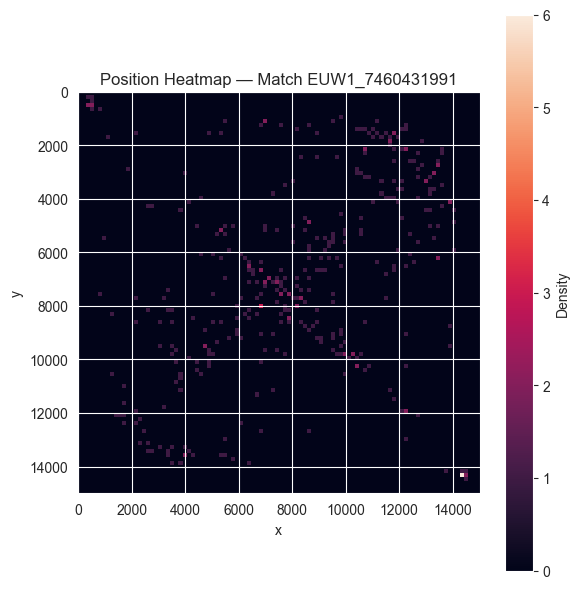

In [22]:


# 选一局比赛
match_id = pos_df["match_id"].iloc[0]
df = pos_df[pos_df["match_id"] == match_id]

# 2D 直方图（heatmap）
bins = 100  # 网格细度，可调 80~150
H, xedges, yedges = np.histogram2d(df["pos_x"], df["pos_y"], bins=bins, range=[[0,15000],[0,15000]])

plt.figure(figsize=(6,6))
# 注意：imshow 需要把原点放在左上角，同时翻转 y 轴
plt.imshow(H.T, origin="lower", extent=[0,15000,0,15000], aspect="equal")
plt.gca().invert_yaxis()
plt.title(f"Position Heatmap — Match {match_id}")
plt.xlabel("x"); plt.ylabel("y")
plt.colorbar(label="Density")
plt.tight_layout()
plt.show()


In [41]:
# --- A. 逐事件 events（从 frames 提取）---
def build_events(frames: pl.DataFrame) -> pl.DataFrame:
    events = (
        frames
        .select(
            "match_id",
            pl.col("timestamp").alias("frame_ts"),  # 帧级时间
            "minute",
            "events",
        )
        .explode("events")
        .drop_nulls("events")
        .unnest("events")
        .with_columns([
            (pl.col("frame_ts")/60000).cast(pl.Int64).alias("frame_minute"),
            # 有些事件可能没有 event_ts，用帧 minute 兜底
            pl.when(pl.col("timestamp").is_not_null())
              .then((pl.col("timestamp")/60000).cast(pl.Int64))
              .otherwise(pl.col("minute"))
              .alias("event_minute"),
            pl.col("position").struct.field("x").alias("pos_x"),
            pl.col("position").struct.field("y").alias("pos_y"),
        ]).drop("position", strict=False)
        # 常见键保留：type, killerId, victimId, assistingParticipantIds,
        # itemId, monsterType, monsterSubType, buildingType, towerType, bounty, etc.
    )
    return events

events = build_events(frames)

events

In [30]:




# --- B. 逐帧逐人快照 participant_snapshots（从 frames 提取）---
#   包含：pos_x/pos_y, totalGold, xp, minionsKilled, jungleMinionsKilled, damageStats, championStats ...
def build_participant_snapshots(frames: pl.DataFrame) -> pl.DataFrame:
    ps = (
        frames
        .select(["match_id", "minute", "timestamp", "participantFrames"])
        .explode("participantFrames")
        .drop_nulls("participantFrames")
        .unnest("participantFrames")
        .with_columns([
            pl.col("position").struct.field("x").alias("pos_x"),
            pl.col("position").struct.field("y").alias("pos_y"),
        ]).drop("position", strict=False)
        # participantId: 1..10
        .with_columns([
            pl.when(pl.col("participantId") <= 5).then(100).otherwise(200).alias("team_id")
        ])
    )
    return ps

# --- C. matches（每场）— 从 decoded + events/participant_snapshots 派生关键聚合 ---
def build_matches(decoded: pl.DataFrame, events: pl.DataFrame, ps: pl.DataFrame) -> pl.DataFrame:
    # 首龙/首先锋
    first_objectives = (
        events
        .filter(pl.col("type") == "ELITE_MONSTER_KILL")
        .with_columns([
            pl.when(pl.col("monsterType") == "DRAGON").then(1).otherwise(0).alias("is_dragon"),
            pl.when(pl.col("monsterType") == "RIFTHERALD").then(1).otherwise(0).alias("is_herald"),
        ])
        .groupby("match_id")
        .agg([
            pl.when(pl.col("is_dragon") == 1).then(pl.col("timestamp")).min().alias("first_dragon_ts"),
            pl.when(pl.col("is_herald") == 1).then(pl.col("timestamp")).min().alias("first_herald_ts"),
            pl.sum(pl.col("is_dragon")).alias("dragon_count"),
            pl.sum(pl.col("is_herald")).alias("herald_count"),
            pl.count().alias("elite_kills"),
        ])
    )

    # 团队金差 @ 5/10/15
    def team_gold_at(minute):
        at_m = (
            ps.filter(pl.col("minute") == minute)
              .groupby(["match_id","team_id"])
              .agg(pl.col("totalGold").sum().alias("team_gold"))
              .pivot(values="team_gold", index="match_id", columns="team_id")
              .rename({"100":"gold_100","200":"gold_200"})
              .with_columns((pl.col("gold_100") - pl.col("gold_200")).alias(f"team_gold_diff@{minute}"))
              .select(["match_id", f"team_gold_diff@{minute}"])
        )
        return at_m

    tg5  = team_gold_at(5)
    tg10 = team_gold_at(10)
    tg15 = team_gold_at(15)

    matches = (
        decoded
        .with_columns([
            (pl.col("gameDuration") if "gameDuration" in decoded.columns else pl.col("game_duration")).alias("game_duration"),
            (pl.col("endOfGameResult") if "endOfGameResult" in decoded.columns else pl.col("end_result")).alias("end_result"),
            (pl.col("teamEarlySurrendered").cast(pl.Boolean) if "teamEarlySurrendered" in decoded.columns else pl.lit(None)).alias("early_ff_flag"),
        ])
        .select([
            "match_id", "queue_id", "game_version", "game_duration", "end_result", "early_ff_flag"
        ])
        .join(first_objectives, on="match_id", how="left")
        .join(tg5, on="match_id", how="left")
        .join(tg10, on="match_id", how="left")
        .join(tg15, on="match_id", how="left")
    )
    return matches


In [31]:
# 计算 CS@10/14、Gold@10、XP diff@10、镀层、参团率 等
def build_participants_from_timeline(ps: pl.DataFrame, events: pl.DataFrame) -> pl.DataFrame:
    # minute 切片
    snap10 = ps.filter(pl.col("minute") == 10).select(["match_id","participantId","team_id","totalGold","xp","minionsKilled","jungleMinionsKilled"])
    snap14 = ps.filter(pl.col("minute") == 14).select(["match_id","participantId","minionsKilled","jungleMinionsKilled"]).rename({"minionsKilled":"minionsKilled14","jungleMinionsKilled":"jungleMinionsKilled14"})

    # CS@10 / @14
    cs10 = (
        snap10
        .with_columns((pl.col("minionsKilled")+pl.col("jungleMinionsKilled")).alias("cs10"))
        .select(["match_id","participantId","team_id","totalGold","xp","cs10"])
        .rename({"totalGold":"gold10","xp":"xp10"})
    )
    cs14 = (
        snap14
        .with_columns((pl.col("minionsKilled14")+pl.col("jungleMinionsKilled14")).alias("cs14"))
        .select(["match_id","participantId","cs14"])
    )

    # XP diff@10（对位：1-6,2-7,3-8,4-9,5-10 近似）
    lane_pairs = (
        cs10
        .with_columns([
            (pl.col("participantId") + 5).alias("opp_pid_tmp")
        ])
        .with_columns([
            pl.when(pl.col("participantId") <= 5).then(pl.col("opp_pid_tmp")).otherwise(pl.col("participantId") - 5).alias("opp_pid")
        ])
        .select(["match_id","participantId","xp10","opp_pid"])
        .join(cs10.select(["match_id","participantId","xp10"]).rename({"participantId":"opp_pid","xp10":"xp10_opp"}), on=["match_id","opp_pid"], how="left")
        .with_columns((pl.col("xp10") - pl.col("xp10_opp")).alias("xpdiff10"))
        .select(["match_id","participantId","xpdiff10"])
    )

    # 镀层（TURRET_PLATE_DESTROYED 计数 & 参与）
    plates = (
        events
        .filter(pl.col("type") == "TURRET_PLATE_DESTROYED")
        .with_columns([
            # 无直接参与者字段时，用位置信息 + 最近的 lane 玩家判断较复杂。这里按团队计到最近分钟的靠塔玩家可选，MVP 先做团队总数：
            pl.lit(1).alias("plate_cnt")
        ])
        .groupby("match_id")
        .agg(pl.sum("plate_cnt").alias("plates_total"))
    )

    # 参团率：击杀相关事件参与（killerId 或 assistingParticipantIds 含我） / 队伍总击杀
    fights = events.filter(pl.col("type") == "CHAMPION_KILL").with_columns([
        pl.col("assistingParticipantIds").list.lengths().fill_null(0).alias("assist_n"),
    ])

    team_kills = (
        fights
        .with_columns([
            pl.when(pl.col("killerId") <= 5).then(100).otherwise(200).alias("team_id_killer")
        ])
        .groupby(["match_id","team_id_killer"])
        .agg(pl.count().alias("team_kill_count"))
        .rename({"team_id_killer":"team_id"})
    )

    me_involved = (
        fights
        .select(["match_id","killerId","assistingParticipantIds"])
        .with_columns([
            pl.concat_list([pl.col("assistingParticipantIds"), pl.col("killerId").cast(pl.List(pl.Int64))]).alias("involved_list")
        ])
        .explode("involved_list")
        .rename({"involved_list":"participantId"})
        .groupby(["match_id","participantId"])
        .agg(pl.count().alias("kill_involvements"))
    )

    # 汇总
    participants_tl = (
        cs10.join(cs14, on=["match_id","participantId"], how="left")
            .join(xpdiff10, on=["match_id","participantId"], how="left")
            .join(me_involved, on=["match_id","participantId"], how="left")
            .join(team_kills, on=["match_id","team_id"], how="left")
            .with_columns([
                pl.col("kill_involvements").fill_null(0),
                pl.col("team_kill_count").fill_null(0),
                pl.when(pl.col("team_kill_count")>0)
                  .then(pl.col("kill_involvements")/pl.col("team_kill_count"))
                  .otherwise(0.0).alias("kill_participation")
            ])
            .select([
                "match_id","participantId","team_id",
                "cs10","cs14","gold10","xpdiff10","kill_involvements","team_kill_count","kill_participation"
            ])
    )

    # 将比赛级的 plates_total 合并（如需人均/分路拆分，可进一步用位置匹配）
    participants_tl = participants_tl.join(plates, on="match_id", how="left")

    return participants_tl


In [32]:
def detect_teamfights(events: pl.DataFrame, window_ms: int = 12000, min_participants: int = 4) -> pl.DataFrame:
    base = (
        events
        .filter(pl.col("type").is_in(["CHAMPION_KILL","ELITE_MONSTER_KILL","BUILDING_KILL"]))
        .with_columns([
            (pl.col("timestamp") // window_ms).alias("time_bucket"),
            pl.col("assistingParticipantIds").alias("assist_list")
        ])
        .with_columns([
            pl.when(pl.col("assist_list").is_null())
              .then(pl.lit([]))
              .otherwise(pl.col("assist_list"))
              .alias("assist_list")
        ])
        .with_columns([
            pl.concat_list([pl.col("assist_list"), pl.col("killerId").cast(pl.List(pl.Int64)), pl.col("victimId").cast(pl.List(pl.Int64))]).alias("involved")
        ])
        .explode("involved")
        .drop_nulls("involved")
        .groupby(["match_id","time_bucket"])
        .agg([
            pl.n_unique("involved").alias("unique_participants"),
            pl.col("type").list().alias("event_types"),
            pl.min("timestamp").alias("start_ts"),
            pl.max("timestamp").alias("end_ts"),
        ])
        .with_columns([
            (pl.col("end_ts") - pl.col("start_ts")).alias("duration_ms")
        ])
        .filter(pl.col("unique_participants") >= min_participants)
        .with_columns([
            (pl.col("start_ts")/60000).cast(pl.Int64).alias("start_minute"),
            (pl.col("end_ts")/60000).cast(pl.Int64).alias("end_minute"),
        ])
        .sort(["match_id","start_ts"])
    )
    return base


In [33]:
def build_item_timeline(events: pl.DataFrame) -> pl.DataFrame:
    item_ev = (
        events
        .filter(pl.col("type").is_in(["ITEM_PURCHASED","ITEM_SOLD","ITEM_UNDO","ITEM_DESTROYED"]))
        .select(["match_id","timestamp","minute","type","participantId","itemId","pos_x","pos_y"])
        .sort(["match_id","participantId","timestamp"])
    )
    return item_ev


In [34]:
# 需要 match detail 的 team/puuid 关系，或从 timeline 的 participantId→team_id + 你自己的 puuid 映射获得
# 这里给一个基于 "同场同队 + 组合对" 的近似版本（没有 puuid 时可用 summonerName；建议最终用 puuid）
def build_duo_synergy(match_participants_detail: pl.DataFrame) -> pl.DataFrame:
    # 预期列：match_id, puuid, team_id, win
    base = match_participants_detail.select(["match_id","puuid","team_id","win"]).unique()

    # 生成同队二元组
    pairs = (
        base.join(base, on=["match_id","team_id"])
            .filter(pl.col("puuid") < pl.col("puuid_right"))  # 避免自连接与重复
            .select([
                pl.col("puuid").alias("puuid_a"),
                pl.col("puuid_right").alias("puuid_b"),
                "match_id",
                # 胜负一致即可用一侧
                pl.col("win").alias("win_a")
            ])
    )

    duo = (
        pairs.groupby(["puuid_a","puuid_b"])
             .agg([
                 pl.count().alias("games"),
                 pl.sum(pl.col("win_a").cast(pl.Int64)).alias("wins"),
             ])
             .with_columns((pl.col("wins")/pl.col("games")).alias("win_rate"))
             .sort(["games","win_rate"], descending=[True,True])
    )
    return duo


In [35]:
import json

def build_participants_from_match_detail(match_detail_df: pl.DataFrame) -> pl.DataFrame:
    # 预期列：match_id, match_detail_json
    md = (
        match_detail_df
        .select(["match_id","match_detail_json"])
        .with_columns(pl.col("match_detail_json").map_elements(json.loads).alias("md"))
        .with_columns(pl.col("md").struct.field("info").alias("info"))
        .with_columns(pl.col("info").struct.field("participants").alias("p_list"))
        .explode("p_list")
        .unnest("p_list")
        .select([
            "match_id",
            "puuid","summonerName","teamId","championId","championName","individualPosition","lane","role",
            "kills","deaths","assists","totalDamageDealtToChampions","totalDamageTaken","timeCCingOthers","largestKillingSpree",
            "goldEarned","totalMinionsKilled","neutralMinionsKilled","visionScore","wardsPlaced","wardsKilled","detectorWardsPlaced",
            "item0","item1","item2","item3","item4","item5","item6","perks",
            "summoner1Id","summoner2Id","win"
        ])
        .rename({
            "teamId":"team_id",
            "individualPosition":"position",
            "totalDamageDealtToChampions":"damage_to_champs",
            "totalDamageTaken":"damage_taken",
            "goldEarned":"gold_earned",
            "totalMinionsKilled":"cs_lane",
            "neutralMinionsKilled":"cs_jungle"
        })
    )
    return md

# 合并 timeline 衍生（cs10/gold10/xpdiff10/kill_participation 等）
def merge_participant_metrics(participants_md: pl.DataFrame, participants_tl: pl.DataFrame) -> pl.DataFrame:
    return (
        participants_md
        .join(participants_tl.rename({"participantId":"pid_from_tl"}), left_on=["match_id","team_id"], right_on=["match_id","team_id"], how="left")
        # 注意：match detail 没有 TL 的 participantId；严格映射需要你已有 “puuid ↔ participantId” 的字典（可从 metadata.participants 顺序或辅助表获得）
        # 如你已有人物映射表 mapping(match_id, puuid, participantId)，请在 join 之前先把 participants_md 也 join 上 participantId 再合并。
    )


In [37]:
# 已有 decoded, frames:

ps     = build_participant_snapshots(frames)

matches = build_matches(decoded, events_all, ps)
participants_tl = build_participants_from_timeline(ps, events)
items_timeline  = build_item_timeline(events)
teamfights      = detect_teamfights(events)

# 如果有赛后摘要 JSON：
# match_detail_df: [match_id, match_detail_json]
# participants_md  = build_participants_from_match_detail(match_detail_df)
# participants_all = merge_participant_metrics(participants_md, participants_tl)


InvalidOperationError: `explode` operation not supported for dtype `struct[16]`